In [140]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\broni\Downloads\cleaned_dataset.csv")

# Assuming the dataset has columns 'article' and 'highlights'
df = df[['article', 'highlights']]

# If your dataset is larger than 5000 records, we will randomly select 5000 records
df = df.sample(n=5000, random_state=42)


In [141]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [142]:
# Parameters
max_text_len = 100  # Input sequence length
max_summary_len = 100  # Output sequence length
max_words = 20000  # Maximum number of words in vocabulary

In [143]:
# Tokenize the articles
tokenizer_article = Tokenizer(num_words=max_words)
tokenizer_article.fit_on_texts(df['article'].values)
article_sequences = tokenizer_article.texts_to_sequences(df['article'].values)

In [144]:
# Tokenize the summaries
tokenizer_summary = Tokenizer(num_words=max_words)
tokenizer_summary.fit_on_texts(df['highlights'].values)
summary_sequences = tokenizer_summary.texts_to_sequences(df['highlights'].values)

In [145]:
# Pad sequences to ensure the same shape
x = pad_sequences(article_sequences, maxlen=max_text_len, padding='post')
y = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

In [146]:
# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [147]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding

In [148]:
# Define the input layer
inputs = Input(shape=(max_text_len,))

In [149]:
# Embedding layer
embedding_layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_text_len)(inputs)

c:\ishant_project\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [150]:
# GRU layer
gru_layer = GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

In [152]:
# Dense output layer
outputs = Dense(max_words, activation='softmax')(gru_layer)

In [153]:
# Define the model
model = Model(inputs=inputs, outputs=outputs)

In [154]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [155]:
from tensorflow.keras.callbacks import EarlyStopping

In [156]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [157]:
# Training the model
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.6169 - loss: 14.3629 - val_accuracy: 0.6959 - val_loss: 9.5106
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2771 - loss: 9.5002 - val_accuracy: 0.0024 - val_loss: 9.5926
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.0029 - loss: 9.3924 - val_accuracy: 8.3000e-04 - val_loss: 8.9966
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.1285 - loss: 7.9718 - val_accuracy: 0.6959 - val_loss: 7.2288
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.7031 - loss: 12.0796 - val_accuracy: 0.6923 - val_loss: 8.0641
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6428 - loss: 25.0914 - val_accuracy: 0.6274 - val_loss: 7.8057
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.6733 - loss: 6.9459 - val_accuracy: 0.6959 - val_loss: 6.8257
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.7002 - loss: 4.8710 - val_accuracy: 0.6

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding
from kerastuner import HyperModel

class TextSummarizationHyperModel(HyperModel):
    def __init__(self, max_text_len, max_words):
        self.max_text_len = max_text_len
        self.max_words = max_words

    def build(self, hp):
        inputs = Input(shape=(self.max_text_len,))
        
        # Embedding layer with tunable output dimension
        embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
        embedding_layer = Embedding(input_dim=self.max_words, output_dim=embedding_dim, input_length=self.max_text_len)(inputs)
        
        # GRU layer with tunable units
        gru_units = hp.Int('gru_units', min_value=128, max_value=512, step=64)
        gru_layer = GRU(gru_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
        
        # Dense output layer
        outputs = Dense(self.max_words, activation='softmax')(gru_layer)
        
        # Define the model
        model = Model(inputs=inputs, outputs=outputs)
        
        # Compile the model with a tunable learning rate
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model


C:\Users\broni\AppData\Local\Temp\ipykernel_4620\442816000.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [168]:
from kerastuner.tuners import RandomSearch

# Initialize the hypermodel
hypermodel = TextSummarizationHyperModel(max_text_len=100, max_words=20000)

# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of trials to run for each combination
    directory='hyperparameter_tuning',
    project_name='text_summarization_gru'
)


In [169]:
# Perform the hyperparameter search
tuner.search(x_train, y_train,
             epochs=10,  # Shorter training for each trial
             validation_data=(x_val, y_val),
             callbacks=[early_stopping])


Trial 10 Complete [00h 15m 39s]
val_loss: 4.937037706375122

Best val_loss So Far: 4.937037706375122
Total elapsed time: 02h 34m 46s


In [170]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the GRU layer is {best_hps.get('gru_units')},
the optimal embedding dimension is {best_hps.get('embedding_dim')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the GRU layer is 256,
the optimal embedding dimension is 256,
and the optimal learning rate is 0.01.



In [171]:
# Build the best model and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.1641 - loss: 5812.7729 - val_accuracy: 0.6639 - val_loss: 4.1951
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6913 - loss: 75818.7109 - val_accuracy: 0.6273 - val_loss: 5.0294
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6916 - loss: 546778.2500 - val_accuracy: 0.0711 - val_loss: 8.5414
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6973 - loss: 486270.9375 - val_accuracy: 0.3822 - val_loss: 6.8866


In [177]:
# Evaluate the model on the validation set (or test set if available)
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.6681 - loss: 4.1492
Validation Loss: 4.195096492767334
Validation Accuracy: 0.6638699173927307


In [173]:
# Save the model
model.save('text_summarization_gru_best_model.h5')

In [180]:
import pickle

# Save the model in the new Keras format
model.save('text_summarization_gru_best_model_final.keras')



# Save the tokenizer for future use
with open('tokenizer_article.pkl', 'wb') as f:
    pickle.dump(tokenizer_article, f)

with open('tokenizer_summary.pkl', 'wb') as f:
    pickle.dump(tokenizer_summary, f)


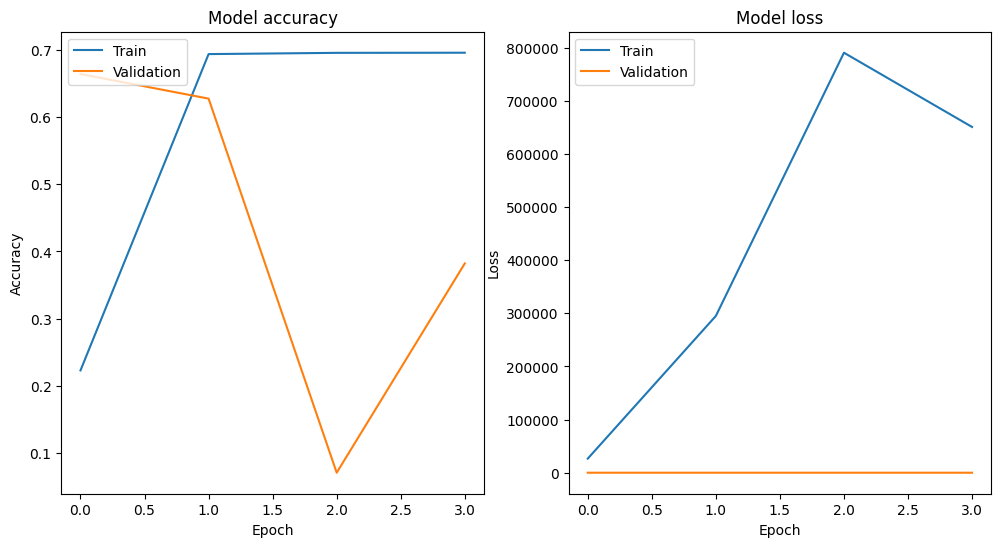

In [176]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
